## Prediction using Prophet as well as SARIMAX

In [37]:
import pandas as pd
import prophet as Prophet
import predhelp as ph
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING) 
logging.propagate = False

Importing modules for Prophet

In [10]:
df = pd.read_csv("../data/total_df.csv").drop(columns=["Unnamed: 0"])
df["DATE"] = pd.to_datetime(df["DATE"])

reparing df for prophet to work with

In [11]:
kol = df.columns.to_list()
add_regs_list=[]
for i in range(230):
    add_regs_list.append("add"+str(i+1))
add_regs_list
rename_df = dict(zip(kol,add_regs_list))
rename_df['DATE'] = "ds"
rename_df['Herkunftsland - Total'] = "y"

renaming DF with new column names:

In [12]:
df.rename(columns={"DATE":"ds","Herkunftsland - Total":"y"},inplace=True)

dropping all the country visitors - otherwise predictions would only take those into account

In [13]:
listen = ['Argentina',
 'Australien',
 'Austria',
 'Bahrain',
 'Belarus',
 'Belgium',
 'Brasil',
 'Bulgaria',
 'Canada',
 'China',
 'Croatia',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Egypt',
 'Estonia',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Hongkong',
 'Hungary',
 'Iceland',
 'India',
 'Indonesia',
 'Ireland',
 'Israel',
 'Italy',
 'Japan',
 'Kuwait',
 'Latvia',
 'Liechtenstein',
 'Lithuania',
 'Luxembourg',
 'Malaysia',
 'Malta',
 'Mexico',
 'Netherlands',
 'New Zealand',
 'Norway',
 'Oman',
 'Philippinen',
 'Poland',
 'Portugal',
 'Qatar',
 'Romania',
 'Russia',
 'Saudi Arabia',
 'Serbia',
 'Singapore',
 'Slovakia',
 'Slovenia',
 'South Africa',
 'South Korea',
 'Spain',
 'Sweden',
 'Switzerland',
 'Taiwan',
 'Thailand',
 'Turkey',
 'Ukraine',
 'United Arab Emirates',
 'United Kingdom',
 'United States']

In [14]:
df.drop(columns=listen,inplace=True)

Now we're going to simulate the first Prophet prediction without adding regressors

Fitting dataframe into Prophet

In [15]:
m = Prophet.Prophet(yearly_seasonality=True)
m.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/7eeo74so.json
DEBUG:cmdstanpy:input tempfile: /var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/vfuk9q_1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/Caskroom/miniconda/base/envs/DSF/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82437', 'data', 'file=/var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/7eeo74so.json', 'init=/var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/vfuk9q_1.json', 'output', 'file=/var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/prophet_modeltw9nxlxm/prophet_model-20221205231206.csv', 'method=optimize', 'algorithm=lbfgs'

making a new DF for our prediction for the future<br>

In [16]:
future = m.make_future_dataframe(periods=6, freq = 'MS')
future.tail()

ds
118 2022-11-01
119 2022-12-01
120 2023-01-01
121 2023-02-01
122 2023-03-01

getting prophet to forecast future guest numbers into the new future-df based on the data in our original df<br>

In [17]:
forecast_m = m.predict(future)

Cross validating data and getting performance metrics

In [18]:
df_cv_m = cross_validation(model=m, horizon=pd.to_timedelta(30*12, unit="D"))

INFO:prophet:Making 12 forecasts with cutoffs between 2016-04-05 00:00:00 and 2021-09-06 00:00:00
  0%|          | 0/12 [00:00<?, ?it/s]DEBUG:cmdstanpy:input tempfile: /var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/hfn7th7s.json
DEBUG:cmdstanpy:input tempfile: /var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/4kipf02b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/Caskroom/miniconda/base/envs/DSF/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73707', 'data', 'file=/var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/hfn7th7s.json', 'init=/var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/4kipf02b.json', 'output', 'file=/var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/prophet_modelzx_akerb/prophet_model-20221205231227.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:12:27 - cmdstanpy - INFO - Chain [1] start pro

Getting performance metrics

In [19]:
df_p_m = performance_metrics(df_cv_m)
m_mean_mae = np.mean(df_p_m['mae'])
m_mean_rmse = np.mean(df_p_m['rmse'])
m_mean_smape = np.mean(df_p_m['smape'])

Plotting results

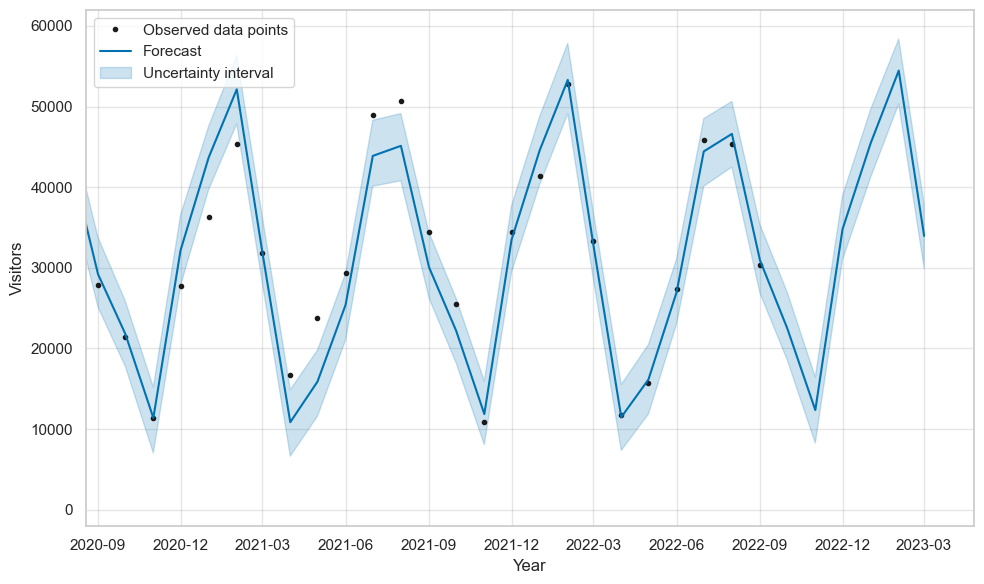

In [20]:
fig = m.plot(forecast_m, include_legend= True, xlabel = 'Year', ylabel = 'Visitors')
ax = fig.gca()
# setting x limit. date range to plot
ax.set_xlim(pd.to_datetime(['2020-08-19', '2023-04-25']))
#fig.suptitle('Prophet Prediction without Regressors')
plt.show()

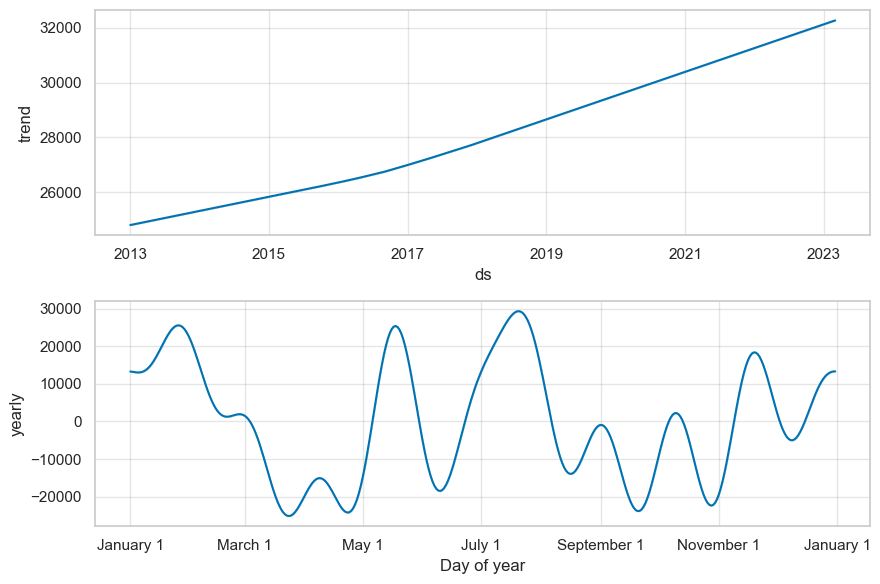

In [22]:
m.plot_components(forecast_m);

Now trying to fit some exogenous variables and be a bit more precise so lets check the correlation first:

In [23]:
df.corrwith(df["y"]).nsmallest(6)

KRW100_exrate   -0.195632
SGD1_exrate     -0.179461
G-7_unemprate   -0.171011
GRC_unemprate   -0.169988
CNY100_exrate   -0.166558
LUX_unemprate   -0.165364
dtype: float64

In [24]:
df.corrwith(df["y"]).nlargest(9)

y                           1.000000
guests-St. Moritz           0.915273
guests-Arosa                0.820817
guests-Zermatt              0.807539
cm avg. snowheight - chd    0.420122
cm avg. snowheight - gsg    0.389059
cm neuschnee - chd          0.291052
eistage - chd               0.277729
frosttage - chd             0.257593
dtype: float64

As we can see we have some very high correlations like st.moritz visitors but also low ones like rainy days with not that much downfall,<br><br>
thus we are going to add our top 5 correlated regressors now that are not other communes.

In [25]:
m2 = Prophet.Prophet(yearly_seasonality=True)
m2.add_regressor("cm avg. snowheight - chd", standardize=False)
m2.add_regressor('cm avg. snowheight - gsg', standardize=False)
m2.add_regressor('cm neuschnee - chd', standardize=False)
m2.add_regressor('eistage - chd', standardize=False)
m2.add_regressor('frosttage - chd', standardize=False)
m2.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/lvnoq25o.json
DEBUG:cmdstanpy:input tempfile: /var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/gau3_z90.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/Caskroom/miniconda/base/envs/DSF/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19497', 'data', 'file=/var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/lvnoq25o.json', 'init=/var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/gau3_z90.json', 'output', 'file=/var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/prophet_modelsvl8g0xc/prophet_model-20221205231342.csv', 'method=optimize', 'algorithm=lbfgs'

Creating future dataframes for all the different regressors

In [26]:
m_snow_chd = Prophet.Prophet(yearly_seasonality=True)
df_snow_chd = df.rename(columns = {'y' : 'bad', 'cm avg. snowheight - chd' : 'y'})
m_snow_chd.fit(df_snow_chd)
future_df_snow_chd = m_snow_chd.make_future_dataframe(periods=6, freq = 'MS')
forecast_snow_chd = m_snow_chd.predict(future_df_snow_chd)
forecast_snow_chd.rename(columns = {'yhat' : 'cm avg. snowheight - chd'}, inplace = True)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/uurd5gdc.json
DEBUG:cmdstanpy:input tempfile: /var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/5g9b1luj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/Caskroom/miniconda/base/envs/DSF/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26511', 'data', 'file=/var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/uurd5gdc.json', 'init=/var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/5g9b1luj.json', 'output', 'file=/var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/prophet_modeljd4vn38d/prophet_model-20221205231432.csv', 'method=optimize', 'algorithm=lbfgs'

In [27]:
m_snow_gsg = Prophet.Prophet(yearly_seasonality=True)
df_snow_gsg = df.rename(columns = {'y' : 'bad', 'cm avg. snowheight - gsg' : 'y'})
m_snow_gsg.fit(df_snow_gsg)
future_df_snow_gsg = m_snow_gsg.make_future_dataframe(periods=6, freq = 'MS')
forecast_snow_gsg = m_snow_gsg.predict(future_df_snow_gsg)
forecast_snow_gsg.rename(columns = {'yhat' : 'cm avg. snowheight - gsg'}, inplace = True)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/ubebyd3b.json
DEBUG:cmdstanpy:input tempfile: /var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/e0v0wgf0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/Caskroom/miniconda/base/envs/DSF/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24168', 'data', 'file=/var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/ubebyd3b.json', 'init=/var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/e0v0wgf0.json', 'output', 'file=/var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/prophet_modelglfa_btv/prophet_model-20221205231439.csv', 'method=optimize', 'algorithm=lbfgs'

In [28]:
m_new_snow = Prophet.Prophet(yearly_seasonality=True)
df_new_snow = df.rename(columns = {'y' : 'bad', 'cm neuschnee - chd' : 'y'})
m_new_snow.fit(df_new_snow)
future_df_new_snow = m_new_snow.make_future_dataframe(periods = 6, freq = 'MS')
forecast_new_snow = m_new_snow.predict(future_df_new_snow)
forecast_new_snow.rename(columns = {'yhat' : 'cm neuschnee - chd'}, inplace = True)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/5q7e6__x.json
DEBUG:cmdstanpy:input tempfile: /var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/ycxp7bdw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/Caskroom/miniconda/base/envs/DSF/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68349', 'data', 'file=/var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/5q7e6__x.json', 'init=/var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/ycxp7bdw.json', 'output', 'file=/var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/prophet_modelm2z14_8g/prophet_model-20221205231443.csv', 'method=optimize', 'algorithm=lbfgs'

In [29]:
m_ice = Prophet.Prophet(yearly_seasonality=True)
df_ice = df.rename(columns = {'y' : 'bad', 'eistage - chd' : 'y'})
m_ice.fit(df_ice)
future_df_ice = m_ice.make_future_dataframe(periods=6, freq = 'MS')
forecast_ice = m_ice.predict(future_df_ice)
forecast_ice.rename(columns = {'yhat' : 'eistage - chd'}, inplace = True)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/1owc9k7u.json
DEBUG:cmdstanpy:input tempfile: /var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/h57o05gj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/Caskroom/miniconda/base/envs/DSF/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9949', 'data', 'file=/var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/1owc9k7u.json', 'init=/var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/h57o05gj.json', 'output', 'file=/var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/prophet_modelslcvp2qu/prophet_model-20221205231447.csv', 'method=optimize', 'algorithm=lbfgs',

In [30]:
m_frost = Prophet.Prophet(yearly_seasonality=True)
df_frost = df.rename(columns = {'y' : 'bad', 'frosttage - chd' : 'y'})
m_frost.fit(df_frost)
future_df_frost = m_frost.make_future_dataframe(periods=6, freq = 'MS')
forecast_frost = m_frost.predict(future_df_frost)
forecast_frost.rename(columns = {'yhat' : 'frosttage - chd'}, inplace = True)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/y5klemwr.json
DEBUG:cmdstanpy:input tempfile: /var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/mx5pbfog.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/Caskroom/miniconda/base/envs/DSF/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96716', 'data', 'file=/var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/y5klemwr.json', 'init=/var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/mx5pbfog.json', 'output', 'file=/var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/prophet_modeliihh1ink/prophet_model-20221205231451.csv', 'method=optimize', 'algorithm=lbfgs'

Creating future dataframe for our main dataframe and merging it with the different regressors.

In [31]:
future_df = m2.make_future_dataframe(periods=6, freq = 'MS')

In [32]:
future_df = pd.merge(future_df, forecast_frost[['frosttage - chd', 'ds']], on = 'ds', how = 'inner')
future_df = pd.merge(future_df, forecast_ice[['eistage - chd', 'ds']], on = 'ds', how = 'inner')
future_df = pd.merge(future_df, forecast_new_snow[['cm neuschnee - chd', 'ds']], on = 'ds', how = 'inner')
future_df = pd.merge(future_df, forecast_snow_gsg[['cm avg. snowheight - gsg', 'ds']], on = 'ds', how = 'inner')
future_df = pd.merge(future_df, forecast_snow_chd[['cm avg. snowheight - chd', 'ds']], on = 'ds', how = 'inner')

Forecasting our dataframe with our different regressors.

In [33]:
forecast_m2 = m2.predict(future_df)

Cross validating

In [34]:
df_cv_m2 = cross_validation(m2, horizon = pd.to_timedelta(30*12, unit="D"))

INFO:prophet:Making 12 forecasts with cutoffs between 2016-04-05 00:00:00 and 2021-09-06 00:00:00
  0%|          | 0/12 [00:00<?, ?it/s]DEBUG:cmdstanpy:input tempfile: /var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/9p5cm1at.json
DEBUG:cmdstanpy:input tempfile: /var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/hzl7o3ou.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/Caskroom/miniconda/base/envs/DSF/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4071', 'data', 'file=/var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/9p5cm1at.json', 'init=/var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/hzl7o3ou.json', 'output', 'file=/var/folders/bn/v98ltrs170dcrqbn6tc0qdb00000gn/T/tmp4fce3nw9/prophet_modelmkv0ir0p/prophet_model-20221205231524.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:15:24 - cmdstanpy - INFO - Chain [1] start proc

Getting our different metrics to compare old prediction with new prediction, namely functions m and m2.

In [35]:
df_p_m2 = performance_metrics(df_cv_m2)
m2_mean_mae = np.mean(df_p_m2['mae'])
m2_mean_rmse = np.mean(df_p_m2['rmse'])
m2_mean_smape = np.mean(df_p_m2['smape'])

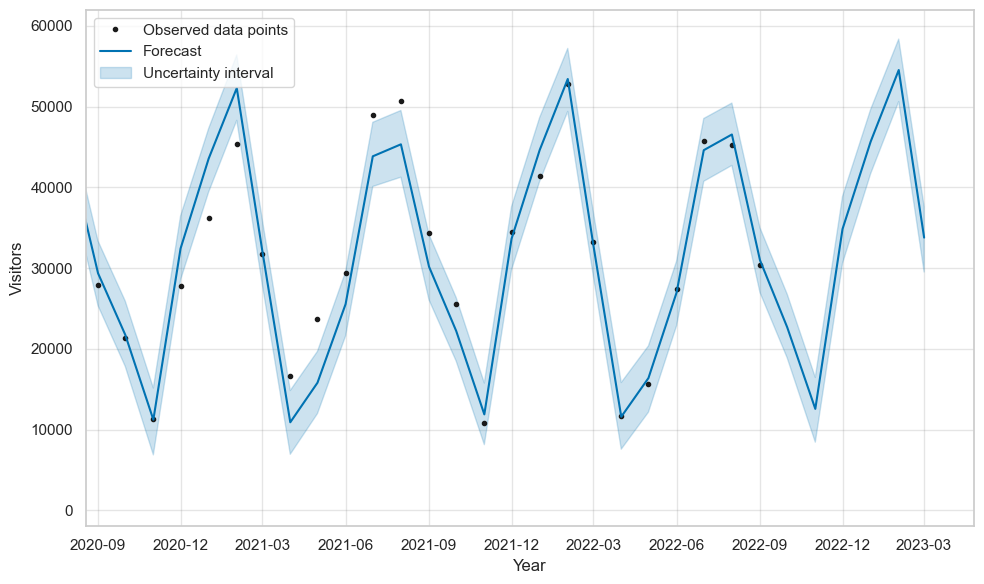

In [38]:
ax1_m2 = m2.plot(forecast_m2, include_legend= True, xlabel = 'Year', ylabel = 'Visitors')
ax = ax1_m2.gca()
# setting x limit. date range to plot
ax.set_xlim(pd.to_datetime(['2020-08-19', '2023-04-25']))
plt.show()

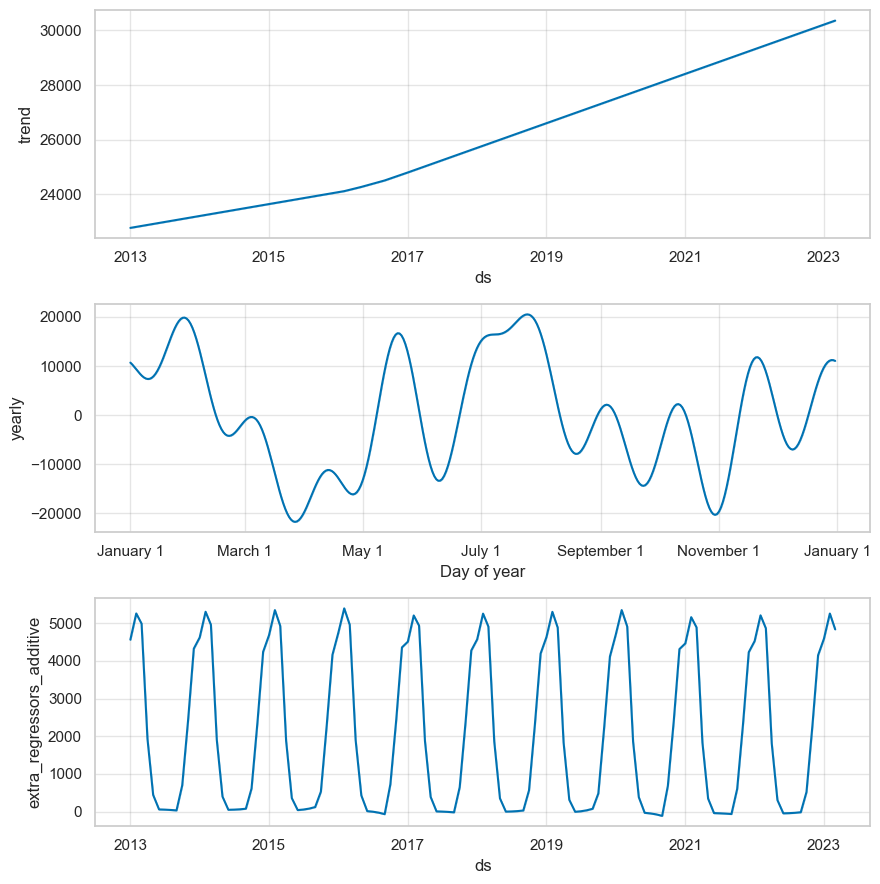

In [39]:
ax2_m2 = m2.plot_components(forecast_m2)

In [40]:
fig_pro, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (12,6), dpi = 1000)
sns.lineplot(data = df_p_m2['rmse'], ax = axs[0,0]).axhline(np.mean(df_p_m2['rmse']), c='red', linestyle='dashed', label="Mean")
sns.lineplot(data = df_p_m2['mae'], ax = axs[1,0]).axhline(np.mean(df_p_m2['mae']), c='red', linestyle='dashed')
sns.lineplot(data = df_p_m2['smape'], ax = axs[2,0]).axhline(np.mean(df_p_m2['smape']), c='red', linestyle='dashed')
sns.lineplot(data = df_p_m['rmse'], ax = axs[0,1]).axhline(np.mean(df_p_m['rmse']), c='red', linestyle='dashed')
sns.lineplot(data = df_p_m['mae'], ax = axs[1,1]).axhline(np.mean(df_p_m['mae']), c='red', linestyle='dashed')
sns.lineplot(data = df_p_m['smape'], ax = axs[2,1]).axhline(np.mean(df_p_m['smape']), c='red', linestyle='dashed')
axs[0,0].set_title('Prediction with Regressors')
axs[0,1].set_title('Prediction without Regressors')
axs[0,0].set_ylim(2400, 7700)
axs[0,1].set_ylim(2400, 7700)
axs[1,0].set_ylim(1700, 5500)
axs[1,1].set_ylim(1700, 5500)
axs[2,0].set_ylim(0.05, 0.47)
axs[2,1].set_ylim(0.05, 0.47)
fig_pro.legend(loc = "lower center")
plt.plot()

[]

In [41]:
df_bar = pd.DataFrame(index = [0])
df_bar['m2_mean_rmse'] = m2_mean_rmse
df_bar['m_mean_rmse'] = m_mean_rmse
df_bar['m2_mean_mae'] = m2_mean_mae
df_bar['m_mean_mae'] = m_mean_mae
df_bar['m2_mean_smape'] = m2_mean_smape
df_bar['m_mean_smape'] = m_mean_smape

In [42]:
fig, ax_bar = plt.subplots(1,3,figsize = (12, 6), dpi = 1000)
palette = sns.color_palette("Paired")
sns.barplot(data = df_bar[['m2_mean_rmse','m_mean_rmse']], ax = ax_bar[0], palette = palette).set(xticklabels=['With Regressors', 'Without Regressors']) 
sns.barplot(data = df_bar[['m2_mean_mae', 'm_mean_mae']], ax = ax_bar[1], palette = palette).set(xticklabels=['With Regressors', 'Without Regressors']) 
sns.barplot(data = df_bar[['m2_mean_smape', 'm_mean_smape']], ax = ax_bar[2], palette = palette).set(xticklabels=['With Regressors', 'Without Regressors']) 
ax_bar[0].set_title('Mean of Root-Mean-Squared Error')
ax_bar[1].set_title('Mean of Mean Absolute Error')
ax_bar[2].set_title('Mean of Symmetric Mean Absolute Percentage Error')
fig.suptitle('Various Metrics for Prophet Predictions with and without regressors')
plt.show()

Using a second model, namely SARIMAX, to predict the visitors in the region

In [43]:
from datetime import timedelta
from datetime import datetime
from time import time
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
RANDOM_SEED = np.random.seed(0)

In [45]:
df = pd.read_csv("../data/total_df.csv").drop(columns=["Unnamed: 0"])
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.set_index("DATE")
df["Herkunftsland - Total"]

DATE
2013-01-01    39240.0
2013-02-01    46474.0
2013-03-01    33899.0
2013-04-01     6839.0
2013-05-01     9308.0
               ...   
2022-05-01    15668.0
2022-06-01    27365.0
2022-07-01    45794.0
2022-08-01    45299.0
2022-09-01    30397.0
Name: Herkunftsland - Total, Length: 117, dtype: float64

list with all the countries so we can drop them for our preds

In [46]:
listen = ['Argentina',
 'Australien',
 'Austria',
 'Bahrain',
 'Belarus',
 'Belgium',
 'Brasil',
 'Bulgaria',
 'Canada',
 'China',
 'Croatia',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Egypt',
 'Estonia',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Hongkong',
 'Hungary',
 'Iceland',
 'India',
 'Indonesia',
 'Ireland',
 'Israel',
 'Italy',
 'Japan',
 'Kuwait',
 'Latvia',
 'Liechtenstein',
 'Lithuania',
 'Luxembourg',
 'Malaysia',
 'Malta',
 'Mexico',
 'Netherlands',
 'New Zealand',
 'Norway',
 'Oman',
 'Philippinen',
 'Poland',
 'Portugal',
 'Qatar',
 'Romania',
 'Russia',
 'Saudi Arabia',
 'Serbia',
 'Singapore',
 'Slovakia',
 'Slovenia',
 'South Africa',
 'South Korea',
 'Spain',
 'Sweden',
 'Switzerland',
 'Taiwan',
 'Thailand',
 'Turkey',
 'Ukraine',
 'United Arab Emirates',
 'United Kingdom',
 'United States',
 "Herkunftsland - Total"]

reparing our df and defining exogenous variables as well as our endogenous variable<br>
reating array with n observations of variables and k number of variables and then filling it

In [47]:
exog = df.drop(columns=listen).to_numpy()
exo = df.drop(columns=listen)
endo = df["Herkunftsland - Total"]

plotting endo to check if it's static, which it seems...

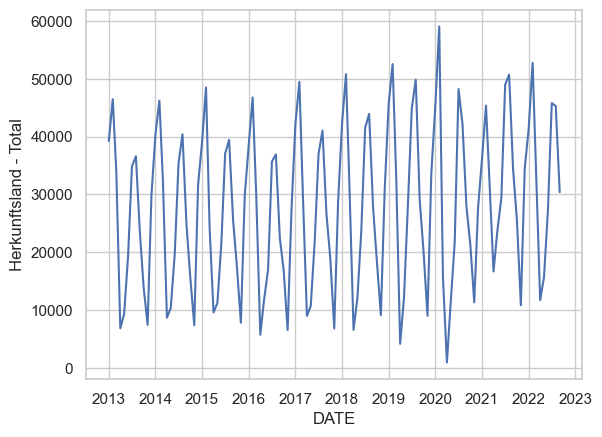

In [48]:
sns.lineplot(endo)
plt.show()

but to be really sure we can check it's stationarity with an augmented dickey-fuller-test

In [49]:
ph.check_stationarity(endo)

The series is NOT stationary according to Dickey-Fuller
The series is NOT stationary according to Kwiatkowski-Phillips-Schmidt-Shin


# Freude herrscht! Apparently it's not - as if it wasn't hard enough already<br><br>
*at least we now know that d is not equal to 0 - but i'll get to that later*

let's try to make endo stationary by removing the trend:<br><br>
we try to do this by taking the difference of between the current value and the prior month's value

The series is stationary according to Dickey-Fuller
The series is NOT stationary according to Kwiatkowski-Phillips-Schmidt-Shin


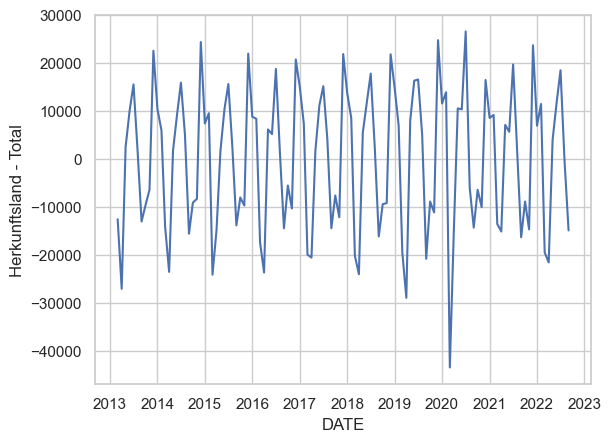

In [50]:
endo_diff = endo.diff()[2:] 
exog_diff = np.diff(exog)[2:] 
# let's check
sns.lineplot(endo_diff)
#and also Dickey-Fuller agrees with us:
ph.check_stationarity(endo_diff)

Dickey-Fuller test shows, that our series is static enough now (even though KPSS, still claims it's not)

now we are using STL decomposition for our DF<br><br>
ecomposing DF into Trend, Seasonality and Residue so we can fit it into our seasonal ARIMA(X)

In [51]:
df_seasonal = seasonal_decompose(endo, model='additive')

it's important to note a strong seasonal influence - otherwise we use ARIMA(X)

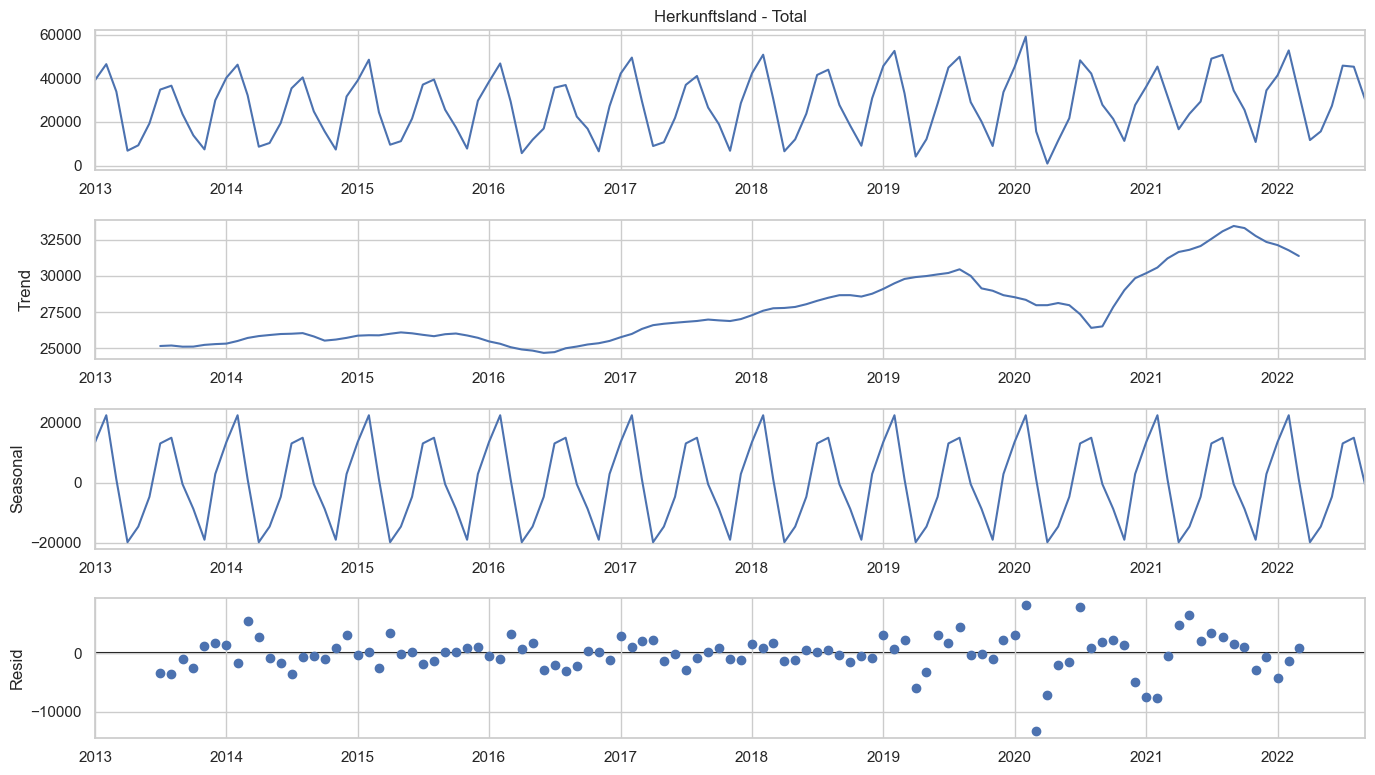

In [52]:
plt.rc('figure',figsize=(14,8))
plt.rc('font',size=15)
df_seasonal.plot();
plt.show()

### Here we can clearly see that there is some kind of trend (*and a remarkable one to say the least*) in our df<br><br>
#### we also notice the big seasonal differences

Trying to evaluate the ideal values of p and q using partial autocorrelation / autocorrelation functions<br><br>

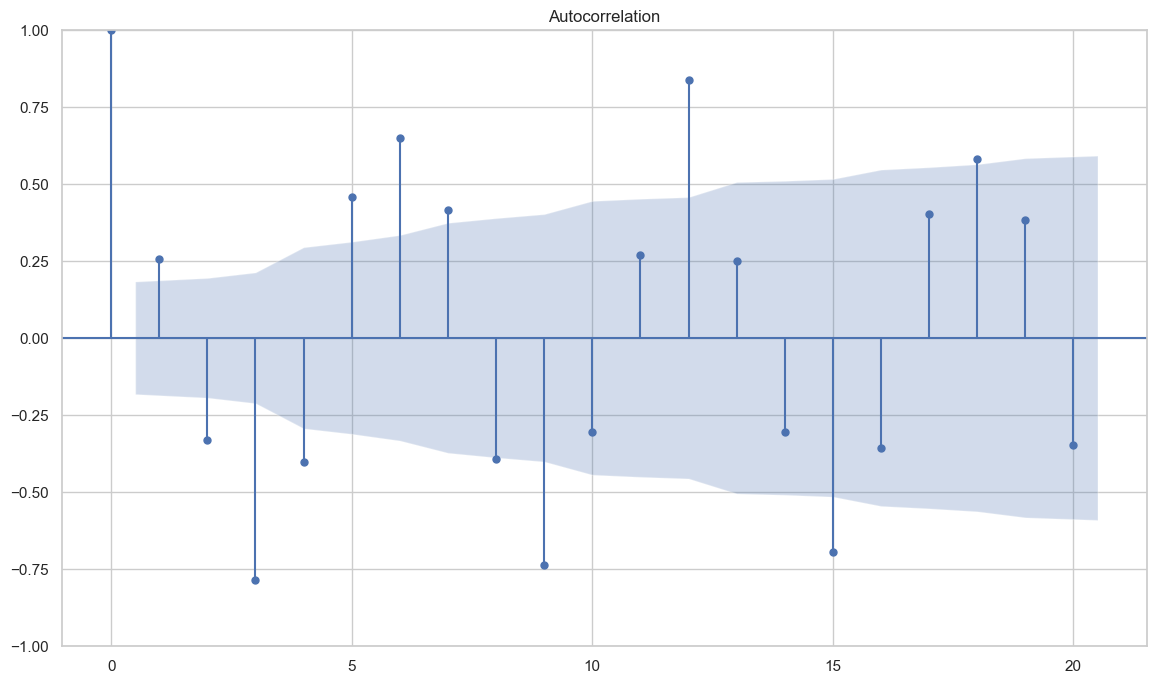

In [53]:
plot_acf(endo_diff, lags=20);9
plt.show()

## **The biggest spike is at the 12 months mark, thus implies we should continue our work with a p value of 12**

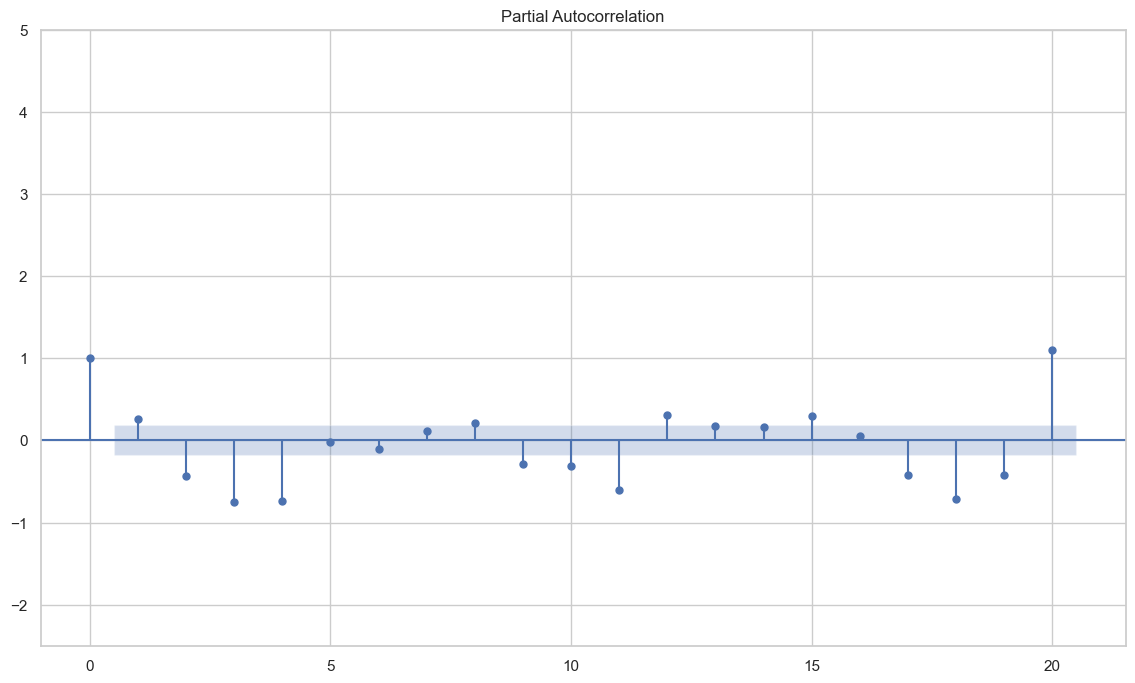

In [54]:
plot_pacf(endo_diff, lags=20)
plt.ylim(-2.5,5)
plt.show()

### There are **VERY** significant spikes at12 in our AFC and PAFC plot. - the huge spike at the 16 month could be covid -idk tho
# Let's get training and testing sets now. so we can make sure our model works correctly

cross Validation by using sklearns TSSplit

In [55]:
tss = TimeSeriesSplit(n_splits=6)
#split our TS in test and train sets
for train_index, test_index in tss.split(exog):
    exog_train, exog_test = exog[train_index, :], exog[test_index,:]
    endo_train, endo_test = endo.iloc[train_index], endo.iloc[test_index]
    exo_train, exo_test = exo.iloc[train_index], exo.iloc[test_index]

showing train and test set in one plot to get an understanding of the split

<AxesSubplot:xlabel='DATE'>

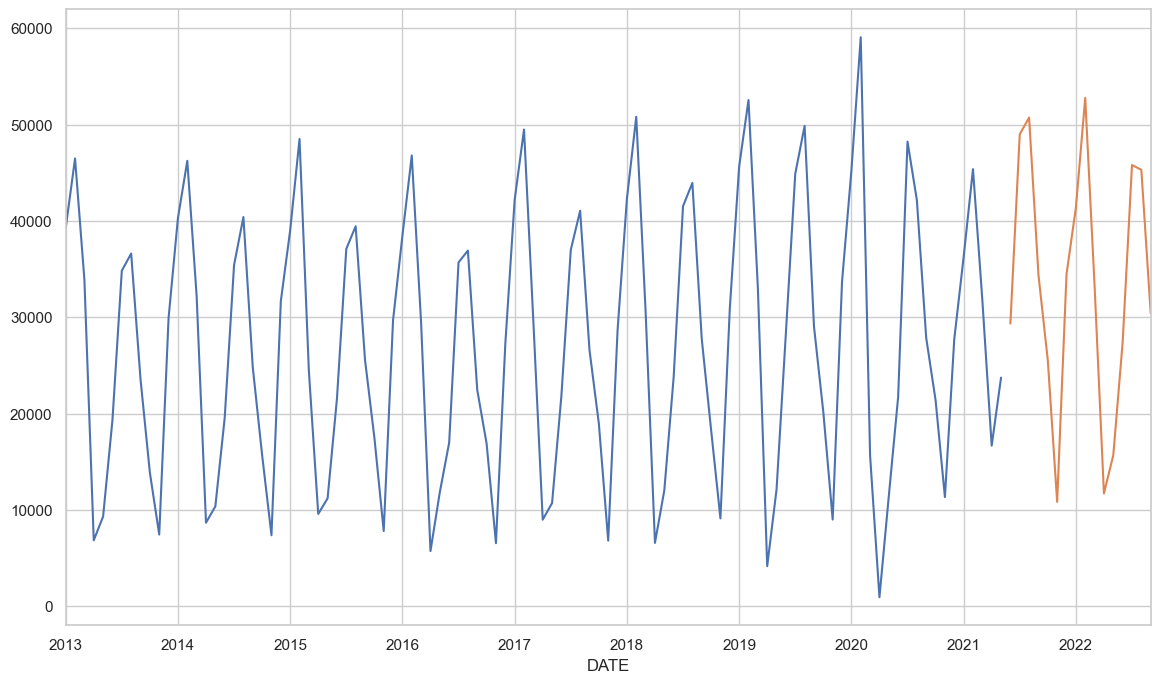

In [56]:
endo_train.groupby('DATE').mean().plot()
endo_test.groupby('DATE').mean().plot()

let's now define our training endos and exos with a d=1 and p=12 // order = pdq is 0,1,0 bc the date is very heavily influenced by seasonality however we were able to appply diff1 to it to integrate it

In [57]:
smodel = SARIMAX(endog=endo_train,exog=exo_train, order=(1,0,0), seasonal_order=(0,0,2,12))

let's fit the model now:

In [58]:
start = time()
fit_smodel = smodel.fit()
end = time()
print("The model took ", end - start,"seconds to be fitted")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          136     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05810D+01    |proj g|=  1.18594D+14


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  136      1     21      1     0     0   1.186D+14  -1.058D+01
  F =  -10.580968150876817     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


The model took  17.550681829452515 seconds to be fitted


In [59]:
forecast = fit_smodel.forecast(len(endo_test), exog=exo_test)
forecast = pd.Series(forecast, index=endo_test.index)
residue = endo_test - forecast

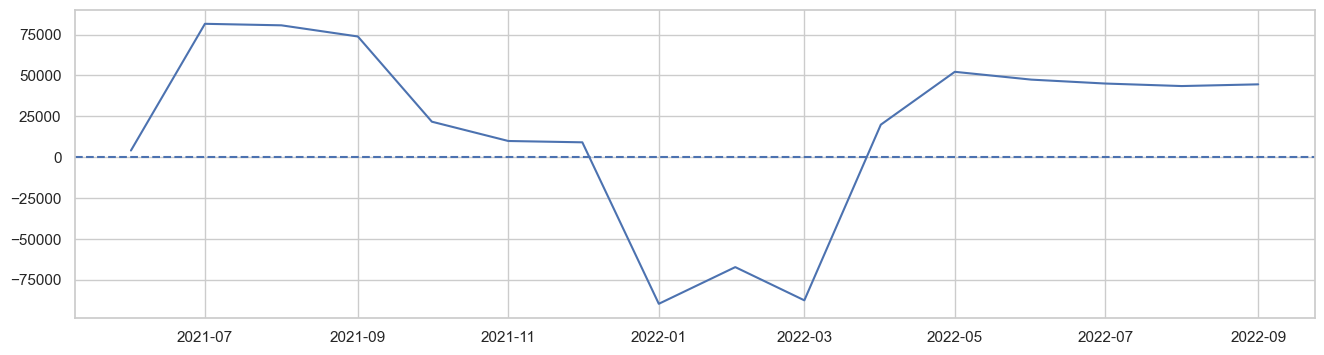

In [60]:
plt.figure(figsize=(16,4))
plt.plot(residue, label="Residual")
plt.axhline(0, linestyle="--")
plt.show()

In [61]:
print("our MAE is", np.mean(np.abs(endo_test - forecast)))

our MAE is 48635.76091266277


Now we can plot our predictions to see whether we were doing alright

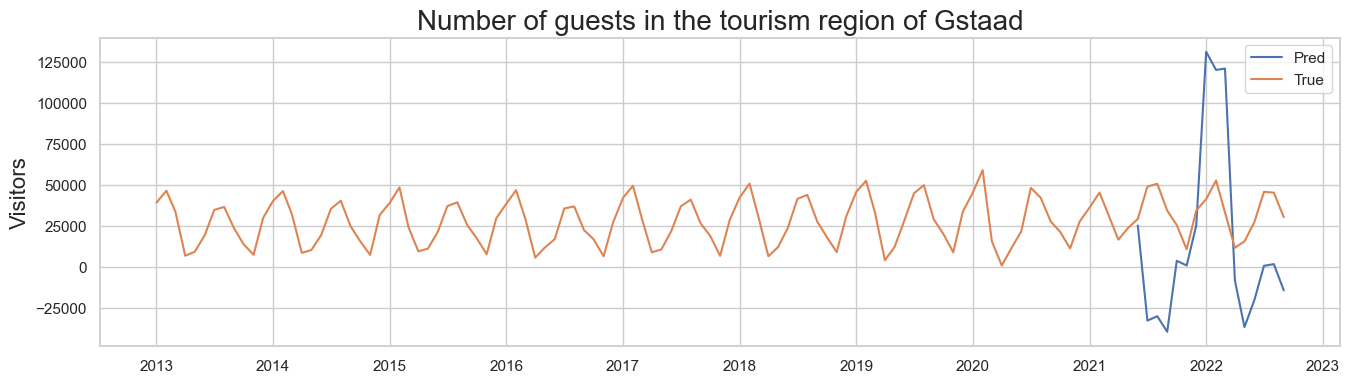

In [62]:
plt.figure(figsize=(16,4))
plt.plot(forecast, label="Pred")
plt.plot(endo, label="True")
#plt.plot(predictions4, label="Predicted3")
plt.title("Number of guests in the tourism region of Gstaad", fontsize=20)
plt.ylabel('Visitors', fontsize=16) 
plt.ylim()
plt.legend()
plt.show()

In [63]:
train_end = datetime(2021,5,1)
test_end = datetime(2022,9,1)
#startparams = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,1,1]

In [64]:
traintrain_exo = exo[train_end:]

In [65]:
rolling_predictions = endo_test.copy()
for train_end in endo_test.index:
    train_data = endo[:train_end-timedelta(days=1)]
    train_exo = exo[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=(1,2,0), seasonal_order=(0,2,1,12),exog=train_exo)
    model_fit = model.fit(start_params=None)
    
    pred = model_fit.forecast(exog=traintrain_exo.loc[[train_end-timedelta()]])
    rolling_predictions[train_end] = pred

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          135     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  1.16371D+05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  135      2     46      2     0     0   3.720D+07  -2.525D+00
  F =  -2.5254563130755985     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          135     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  2.86354D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  135      4     52      1     0     0   4.404D+06  -1.727D+00
  F =  -1.7270827167921814     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          135     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  3.88508D+04


 This problem is unconstrained.


  ys=-9.327E-18  -gs= 4.589E-09 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  135      4     84      2     1     0   7.997D+06  -1.777D+00
  F =  -1.7774095668785785     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          135     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  1.00167D+05


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  135      3     65      2     0     0   3.268D+07  -2.524D+00
  F =  -2.5244891048358706     

ABNORMAL_TERMINATION_IN_LNSRCH                              


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          135     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  4.08201D+04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  135      2     45      2     0     0   7.953D+06  -1.789D+00
  F =  -1.7888911798635376     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          135     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  4.80955D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  135      3     45      1     0     0   3.887D+07  -2.574D+00
  F =  -2.5741075275397933     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          135     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.63186D-01    |proj g|=  1.15022D+12


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  135      1     21      1     0     0   1.150D+12  -2.632D-01
  F = -0.26318578591241215     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          135     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  1.93310D+05


 This problem is unconstrained.


  ys=-2.304E-13  -gs= 3.134E-06 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  135      5     96      2     1     0   7.147D+07  -2.640D+00
  F =  -2.6404691602112202     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          135     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  2.62878D+04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  135      4     83      2     0     0   7.968D+06  -1.810D+00
  F =  -1.8103174171187790     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          135     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  3.67107D+04


 This problem is unconstrained.



At iterate    5    f= -1.81621D+00    |proj g|=  8.35093D+06
  ys=-7.172E-14  -gs= 4.515E-07 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  135      6    102      2     1     0   8.351D+06  -1.816D+00
  F =  -1.8162135911302295     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          135     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  1.55489D+04


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  135      2     45      2     0     0   5.757D+06  -1.811D+00
  F =  -1.8106710938397694     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          135     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  1.45269D+04

At iterate    5    f= -1.79503D+00    |proj g|=  4.80113D+06
  ys=-3.118E-16  -gs= 6.628E-09 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  135      6    113      2     1     0   4.801D+06  -1.795D+00
  F =  -1.7950277217350159     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          135     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  1.15674D+05


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  135      2     46      2     0     0   3.861D+07  -2.637D+00
  F =  -2.6366848398729270     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          135     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.59367D-02    |proj g|=  2.24776D+12


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  135      1     21      1     0     0   2.248D+12  -4.594D-02
  F =  -4.5936736026980923E-002

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          135     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  5.12036D+04


 This problem is unconstrained.


  ys=-3.849E-15  -gs= 2.394E-08 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  135      3     66      2     1     0   8.043D+07  -2.690D+00
  F =  -2.6896950667954749     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          135     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  9.61154D+03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  135      3     41      1     0     0   3.901D+06  -1.747D+00
  F =  -1.7473928921744997     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [66]:
rolling_residuals = endo_test - rolling_predictions

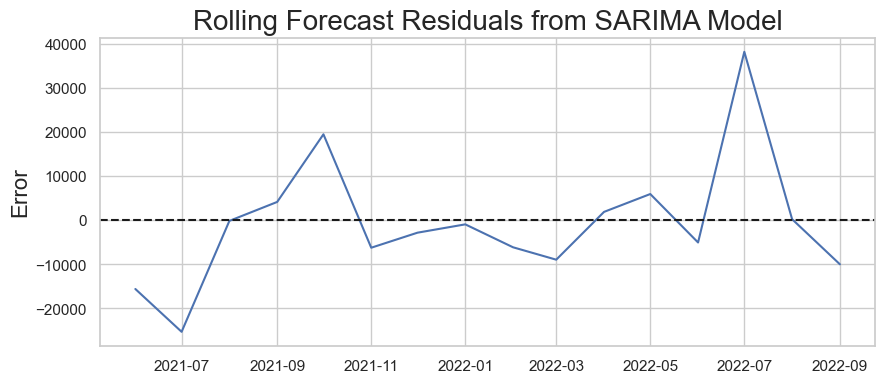

In [67]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.show()

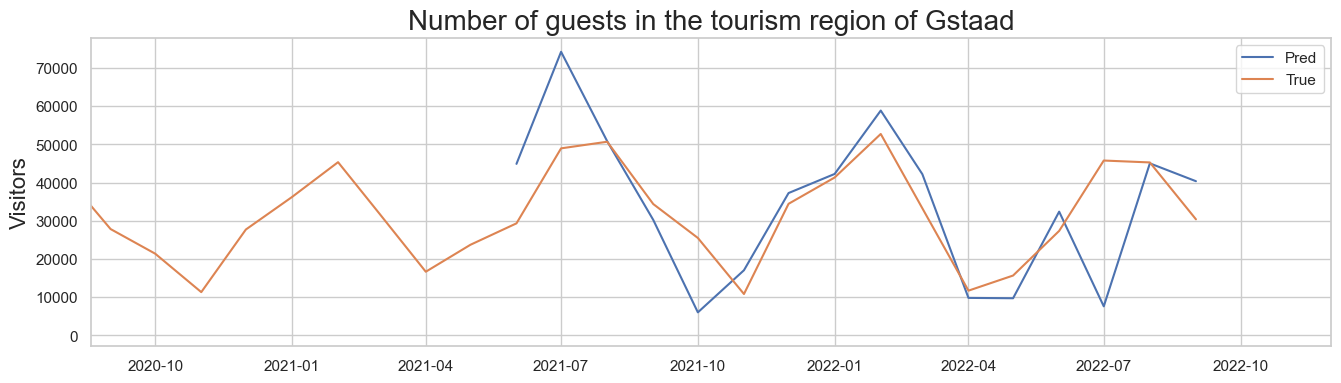

In [68]:
plt.figure(figsize=(16,4))
plt.plot(rolling_predictions, label="Pred")
plt.plot(endo, label="True")
#plt.plot(predictions4, label="Predicted3")
plt.title("Number of guests in the tourism region of Gstaad", fontsize=20)
plt.ylabel('Visitors', fontsize=16) 
plt.xlim(pd.to_datetime(['2020-08-19', '2022-12-01']))
plt.legend()
plt.show()

In [69]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [70]:
df_bar_max = pd.DataFrame(index = [0])
df_bar_max['Mean Absolute Error'] = mean_absolute_error(endo_test, rolling_predictions)
df_bar_max['Root-Mean-Squared Deviation'] = rmse(endo_test, rolling_predictions)
df_bar_max['Symmetric Mean Absolute Percentage Error'] = smape(endo_test, rolling_predictions)
df_bar_max['m_mean_rmse'] = df_bar['m_mean_rmse']
df_bar_max['m_mean_mae']  = df_bar['m_mean_mae']
df_bar_max['m_mean_smape'] = df_bar['m_mean_smape']
df_bar_max['m2_mean_rmse'] = df_bar['m2_mean_rmse']
df_bar_max['m2_mean_mae'] = df_bar['m2_mean_mae']
df_bar_max['m2_mean_smape'] = df_bar['m2_mean_smape']

In [71]:
fig, axss = plt.subplots(1,3, figsize = (15,6), dpi = 1000, constrained_layout=True)
sns.barplot(data = df_bar_max[['Root-Mean-Squared Deviation', 'm_mean_rmse', 'm2_mean_rmse']], ax = axss[0], palette = palette).set(xticklabels = ['SARIMAX', 'Prophet without Reg.', 'Prophet with Reg.'],ylabel = 'Root-Mean-Squared Deviation')
sns.barplot(data = df_bar_max[['Mean Absolute Error', 'm_mean_mae', 'm2_mean_mae']], ax = axss[1], palette = palette).set(xticklabels = ['SARIMAX', 'Prophet without Reg.', 'Prophet with Reg.'],ylabel = 'Mean Absolute Error')
sns.barplot(data = df_bar_max[['Symmetric Mean Absolute Percentage Error','m_mean_smape', 'm2_mean_smape']], ax = axss[2], palette = palette).set(xticklabels = ['SARIMAX', 'Prophet without Reg.', 'Prophet with Reg.'],ylabel = 'Symmetric Mean Absolute Percentage Error')
fig.suptitle('Comparison of Different Metrics between SARIMAX and Prophet Predictions')
plt.show()